<a href="https://colab.research.google.com/github/prashantsingh10psb/BridgeLabz-2415500346/blob/main/ADNI_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Load libraries*

In [13]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


Read data

In [6]:
df = pd.read_csv("ADNIMERGE_synthetic_data.csv")

Data

In [7]:
df

,RID,VISCODE,MONTHS,EXAMDATE,AGE,PTGENDER,PTEDUCAT,APOE4,DX,MMSE,ADAS13,AV45,FDG,HIPPO_VOL_ML,ABETA42_PG_ML,ABETA40_PG_ML,ABETA42_ABETA40_RATIO,PTAU181_PG_ML,TTAU_PG_ML
0,2207,v6,6,2010-06-24,76,F,16,0,MCI,27.9,11.3,1.065,1.140,5.441,847.9,10844.7,0.0782,35.54,357.9
1,2234,v24,24,2011-12-28,85,F,15,0,AD,23.3,35.8,1.331,0.984,5.629,555.7,11355.5,0.0489,34.16,380.0
2,2111,bl,0,2010-01-06,75,F,11,0,CN,29.6,12.2,1.100,1.059,5.605,1355.5,12611.2,0.1075,17.15,217.5
3,2124,v12,12,2011-01-03,74,F,18,1,AD,22.0,50.9,1.388,0.849,5.332,351.2,12089.2,0.0291,81.16,635.9
4,2198,v6,6,2010-07-06,59,M,20,0,CN,30.0,8.4,1.007,1.090,5.771,1021.6,12528.1,0.0815,21.00,130.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,2030,v12,12,2010-12-23,70,M,14,0,CN,29.1,8.9,1.215,1.169,6.218,1171.5,11668.4,0.1004,17.48,191.4
1127,2277,v24,24,2012-01-09,74,F,13,0,MCI,26.9,13.7,1.162,1.092,5.793,1002.6,12236.5,0.0819,28.08,358.8
1128,2292,v6,6,2010-06-26,73,F,15,1,MCI,26.2,6.8,1.069,1.070,5.954,NaN,10316.3,0.1048,36.79,267.2
1129,2226,bl,0,2010-01-03,70,M,12,1,CN,28.7,7.7,1.297,1.141,6.089,1213.2,13476.5,0.0900,27.44,288.3


Checking null values

In [8]:
df.isnull().sum()

,0
RID,0
VISCODE,0
MONTHS,0
EXAMDATE,0
AGE,0
PTGENDER,0
PTEDUCAT,0
APOE4,0
DX,0
MMSE,0


Feature Selection

In [31]:
df = df[df["DX"] == "MCI"]
features = ["ADAS13", "MMSE", "AGE", "PTGENDER"]
X = df[features]


In [32]:
cut = np.percentile(df["ADAS13"], 75)
y = (df["ADAS13"] >= cut).astype(int)



Train,test , split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


Apllying encoding to PTGENDER

In [46]:
from sklearn.preprocessing import OneHotEncoder

categorical_features = ['PTGENDER']

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_categorical = X_train[categorical_features]
X_train_categorical_encoded = ohe.fit_transform(X_train_categorical)

X_test_categorical = X_test[categorical_features]
X_test_categorical_encoded = ohe.transform(X_test_categorical)


Imputation

In [82]:
from sklearn.impute import SimpleImputer

numerical_features = ['ADAS13', 'MMSE', 'AGE']

numerical_imputer = SimpleImputer(strategy="median")

X_train_numerical = X_train[numerical_features]
X_train_numerical_imp = numerical_imputer.fit_transform(X_train_numerical)

X_test_numerical = X_test[numerical_features]
X_test_numerical_imp = numerical_imputer.transform(X_test_numerical)


Applying Model

In [83]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=5,
    max_features="sqrt",
    random_state=42
)

rf.fit(X_train_numerical_imp, y_train)


RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=300,
                       random_state=42)

Performance

In [52]:
y_prob = rf.predict_proba(X_test_numerical_imp)[:, 1]
auc = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc)


AUC Score: 1.0


Optimal Cutoff

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_cutoff = thresholds[optimal_idx]

print("Optimal Cutoff Probability:", optimal_cutoff)


Optimal Cutoff Probability: 0.8540623188405796


Graph

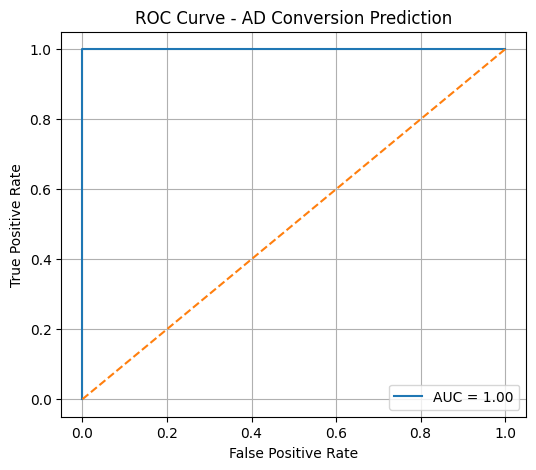

In [54]:
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AD Conversion Prediction")
plt.legend()
plt.grid(True)
plt.show()


Applying Logistic Regression to same data

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

log_reg = LogisticRegression(random_state=42, solver='liblinear')


log_reg.fit(X_train_processed, y_train)

print("Logistic Regression model trained successfully.")

Logistic Regression model trained successfully.


Checking performance

In [81]:

y_pred_log_reg = log_reg.predict(X_test_processed)
y_prob_log_reg = log_reg.predict_proba(X_test_processed)[:, 1]


print("\n Logistic Regression Model Evaluation ")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log_reg))

auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
print(f"\nROC AUC Score: {auc_log_reg:.4f}")


 Logistic Regression Model Evaluation 

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        68
           1       1.00      0.91      0.95        23

    accuracy                           0.98        91
   macro avg       0.99      0.96      0.97        91
weighted avg       0.98      0.98      0.98        91


Confusion Matrix:
[[68  0]
 [ 2 21]]

ROC AUC Score: 1.0000


In [87]:
import pickle
with open('ADNI_Model.py', 'wb') as f:
    pickle.dump(rf,f)